In [107]:
import numpy as np
from scipy import ndimage
from phantominator import shepp_logan, ct_modified_shepp_logan_params_3d
import matplotlib.pyplot as plt

plt.ion()

## Define image rotation function

In [59]:
def to_radians(theta):
    return theta * np.pi / 180.

def rotate_image(image, theta):
    height = np.arange(image.shape[0], dtype=np.float32)
    width = np.arange(image.shape[1], dtype=np.float32)
    slices = np.arange(image.shape[2], dtype=np.float32)
    y_, x_, z_ = np.meshgrid(height / image.shape[0] - 0.5, width / image.shape[1] - 0.5, slices / image.shape[2] - 0.5, indexing='ij')
    x_rot = x_*np.cos(theta) - y_*np.sin(theta)
    y_rot = x_*np.sin(theta) + y_*np.cos(theta)
    x_rot = (x_rot + 0.5)*image.shape[1]
    y_rot = (y_rot + 0.5)*image.shape[0]
    z_rot = (z_ + 0.5) * image.shape[2]
    sample_coords = np.stack([y_rot, x_rot, z_rot], axis=0)
    return ndimage.map_coordinates(image, sample_coords, order=1).reshape(image.shape)

## Load a Shepp-Logan slice

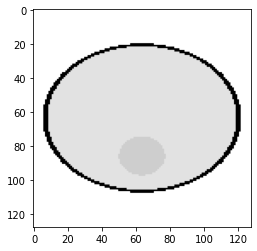

In [110]:
img = shepp_logan((128, 128, 128), zlims=(-1, 1))
plt.imshow(img[:,:,64], cmap='Greys')

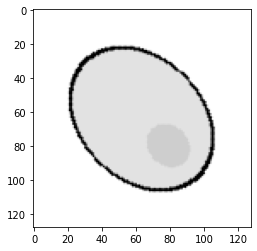

In [102]:
rotated = rotate_image(img, to_radians(45.))
plt.imshow(rotated[:,:,32], cmap='Greys')

## Project image function

In [103]:
def ct_project(image, theta=0):
    if theta != 0:
        image = rotate_image(image, theta)
    res = np.sum(image, axis=0)
    return np.swapaxes(res, 0, 1)

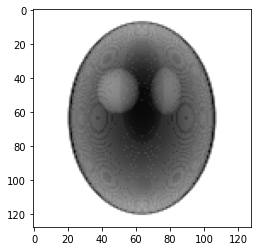

In [104]:
projected = ct_project(image=img)
plt.imshow(projected, cmap="Greys")

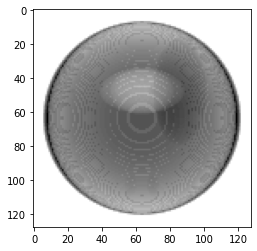

In [105]:
projected = ct_project(image=img, theta=to_radians(90))
plt.imshow(projected, cmap='Greys')

## Coordinate generation

In [10]:
def rotation_2d(t):
    cos_t = np.cos(t)
    sin_t = np.sin(t)
    return np.array([[cos_t, -sin_t], [sin_t, cos_t]])

y = np.linspace(-.5, .5, img.shape[0])
x = np.linspace(-.5, .5, img.shape[1])
train = np.stack(np.meshgrid(x, y), axis=-1)
rot = rotation_2d(to_radians(45.))
train = train @ rot.transpose()
print(train.shape)

(128, 128, 2)


## Test ProjectorDataset

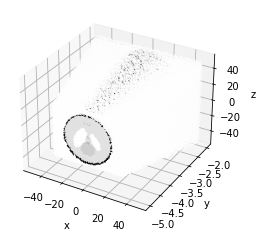

In [14]:
from leaf.ray_tracing import ConeBeamProjector
from leaf.data import ProjectorDataset, MinMaxScaler
from leaf.rendering import LinearRaySampler

# img = np.arange(0, 100).reshape((10, 10))
h2 = img.shape[1] / 2
w2 = img.shape[0] / 2
num_samples = 15
cbp = ConeBeamProjector(pos=(0, -10, 0), lookat=(0,0,0), up=(0,0,1), image=img)
box_min = np.array((-50, -5, -50))
box_max = np.array((50, -2, 50))
sampler = LinearRaySampler(num_samples=num_samples, jitter=True, bounds=(box_min, box_max))
scaler = MinMaxScaler(in_bounds=[[-w2, w2], [-10, 0], [-h2, h2]], out_bounds=[[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]])
dataset = ProjectorDataset([cbp], ray_sampler=sampler)

ss = None
colors = []
for idx in range(0, len(dataset)):
    s, c = dataset[idx]
    # s = scaler.transform(s)
    if ss is None:
        ss = s
    else:
        ss = np.append(ss, s, axis=0)
    colors.extend([c] * num_samples)

x, y, z = np.hsplit(ss, 3)
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter3D(x, y, z, c=colors, cmap='Greys', s=0.25)

np.array_equal(img, img_rec)=True


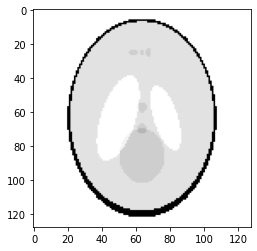

In [12]:
vals = []
for idx in range(len(dataset)):
    samples, val = dataset[idx]
    vals.append(val)
img_rec = np.array(vals).reshape(cbp.proj_size)
print(f'{np.array_equal(img, img_rec)=}')
plt.imshow(img_rec, cmap='Greys')